In [1]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")
using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON
using Gurobi
using PiecewiseLinearOpt
using VegaLite, VegaDatasets
using FileIO

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [2]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 3 entries:
  "BARON"              => v"0.6.5"
  "PiecewiseLinearOpt" => v"0.3.0"
  "CPLEX"              => v"0.7.8"

In [3]:
add_key="_netzero"
innovations = CSV.File("./data-case-roadmap/innovations"*add_key*".csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./data-case-roadmap/map-ki"*add_key*".csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./data-case-roadmap/compromise"*add_key*".csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./data-case-roadmap/initial.csv",header=1,delim=",") |> DataFrame
iam_model = CSV.File("./data/iam_model.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
#innovations

,k,i,GWP,Theta,Per_Recycl,Per_Comp,Ocost
,Int64,Int64,Int64,Float64,Float64,Int64,Float64
1,0,0,8,0.15,0.12,0,3.2


In [4]:
innovations[!,:Cost_per_RL].=100
innovations[5:7,:Cost_per_RL].=200

3-element view(::Vector{Int64}, 5:7) with eltype Int64:
 200
 200
 200

In [5]:

mapki

,i,k_lim,name
,Int64,Int64,String31
1,1,27,LABS from PE
2,2,53,Pyrolysis of LDPE
3,3,80,Pyrolysis of HDPE
4,4,107,Pyrolysis of PP
5,5,133,Recycling back to PLA usin Clay
6,6,156,Alkaline hydrolysis of PLA
7,7,175,Alcoholysis of PLA
8,8,202,Bio-Ethanol
9,9,231,MSW pyrolysis to small olefins


In [6]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end


give_sorted (generic function with 1 method)

In [7]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],digits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],digits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),digits=3)
    s0[1,rl[i],i]=1
end
rl_vals=[1 2 3 4 5]

1×5 Matrix{Int64}:
 1  2  3  4  5

In [8]:
inn_reg = CSV.File("./data-case-roadmap/inn_reg.csv",header=1,delim=",") |> DataFrame
inn_xrang = CSV.File("./data-case-roadmap/inn_xrang.csv",header=1,delim=",") |> DataFrame
inn_yrang = CSV.File("./data-case-roadmap/inn_yrang.csv",header=1,delim=",") |> DataFrame
inn_yrang[!,"Y0"]=-1*(innovations[!,"RL"].-5)
#inn_yrang

11-element Vector{Int64}:
 4
 2
 3
 2
 4
 3
 4
 4
 2
 2
 4

In [9]:
tau=[0,5,10,15,20,25,30]
iam_model

,Yr,Back_RedFr_Elec
,Int64,Float64
1,0,1.0
2,10,0.949785
3,20,0.809146
4,30,0.623735
5,40,0.414707
6,50,0.331447


In [10]:
iam_model[!,:SSP2_26]=[1;0.709400568;0.338927654;0.167450131;0.040623854;-0.007550004]
iam_model[!,:SSP2_34]=[1
0.79201692
0.58673921
0.421703033
0.256391318
0.173374409]
iam_model[!,:SSP2_45]=[1
0.845749028
0.697764574
0.592427808
0.495805938
0.382279665]
iam_model[!,:SSP2_60]=[1
0.863384263
0.756985447
0.698647714
0.646561914
0.57321622
]
iam_model[!,:SSP2_Base]=[1
0.868368691
0.765739022
0.714737561
0.671557877
0.6156889
]
iam_model



,Yr,Back_RedFr_Elec,SSP2_26,SSP2_34,SSP2_45,SSP2_60,SSP2_Base
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,0,1.0,1.0,1.0,1.0,1.0,1.0
2,10,0.949785,0.709401,0.792017,0.845749,0.863384,0.868369
3,20,0.809146,0.338928,0.586739,0.697765,0.756985,0.765739
4,30,0.623735,0.16745,0.421703,0.592428,0.698648,0.714738
5,40,0.414707,0.0406239,0.256391,0.495806,0.646562,0.671558
6,50,0.331447,-0.00755,0.173374,0.38228,0.573216,0.615689


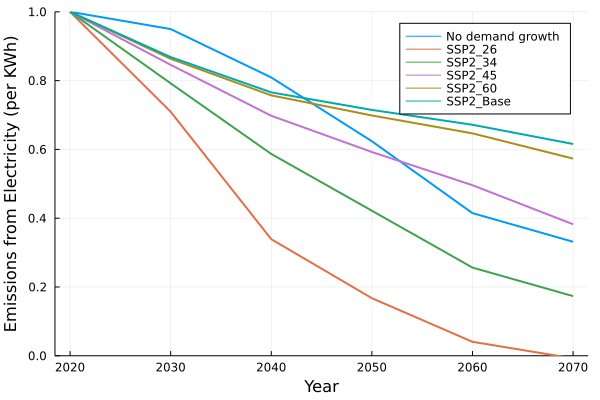

In [11]:
plot(iam_model[!,:Yr].+(2020),iam_model[!,:Back_RedFr_Elec],lw=2, label="No demand growth",ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,3],lw=2, label="SSP2_26",ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,4],lw=2, label="SSP2_34" ,ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,5],lw=2, label="SSP2_45" ,ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,6],lw=2, label="SSP2_60" ,ylims=(0,1))
plot!(iam_model[!,:Yr].+(2020),iam_model[!,7],lw=2, label="SSP2_Base" ,ylims=(0,1))
xlabel!("Year")
ylabel!("Emissions from Electricity (per KWh)")

In [12]:
#1=Back_redFr_elec (No Demand Growth)
#2=SSP2_26
#2=SSP2_34
#2=SSP2_45
#2=SSP2_60
#2=SSP2_Baseline

iam_selection=2
add_identifier=""
output_key=names(iam_model)[iam_selection+1]*add_identifier
want_save=0

0

In [20]:
function tech_roadmap_mccormick_peicewise_iam_multipd(co2_target,circularity_target)
    
    rdmap= Model(Gurobi.Optimizer)
    #rdmap=Model(BARON.Optimizer)
    #set_optimizer_attribute(rdmap, "MaxTime", 250)
    #set_optimizer_attribute(rdmap, "DoLocal", 0)
    #set_optimizer_attribute(rdmap, "NumLoc", 0)
    set_optimizer_attribute(rdmap, "NonConvex", 2)
    
    #Sets
    # i: innovation
    # k: compromise or pareto optimal solution
    # r,c : row column of transition matrices
    
    #Declaration of variables
    
    #binary variable choosing the pareto optimal solution
    @variable(rdmap,yk[k=1:nrow(compromise),tt=1:7],Bin)
    #time at which a pareto optimal solution is chosen
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise),tt=1:7] ≤ 5)
    #percentage of functional unit that a pareto optimal solution takes up
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise),tt=1:7] ≤ 1)
    
    #binary variable choosing which innovation to invest in for adoption
    @variable(rdmap,yi[i=1:nrow(innovations),tt=1:7],Bin)
    #time at which invested is made and innovation made adoptible
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations),tt=1:7] ≤ 5)
    #readiness level state value of ith innovation
    @variable(rdmap, s[i=1:nrow(innovations),tt=1:7] )
    
    #CO2 at 2050 target
    @variable(rdmap, co2_2050[tt=1:7])
    
    #circularity at 2030 target
    @variable(rdmap, theta_2030[tt=1:7] ≥ 0)
    #recycled content at 2030 target
    @variable(rdmap, recycl_2030[tt=1:7] ≥ 0)
    #compostable content at 2030 target
    @variable(rdmap, comp_2030[tt=1:7] ≥ 0)
    
    #integral approximator of CO2
    @variable(rdmap, co2_tot ≥ 0)
    
    #cost incured in investing to adopt
    @variable(rdmap, 0 ≤ cost_inn)
    
    #surrogate models
    @variable(rdmap,f_fit[i=1:nrow(innovations),tt=1:7] ≥ 0)
    @variable(rdmap,co2_factor[k=1:nrow(compromise),tt=1:7])
    @variable(rdmap,co2_corrected[k=1:nrow(compromise),tt=1:7])

    for i in 1:nrow(innovations)
        for tt in 1:7
            f_fit[i,tt] = piecewiselinear(rdmap, tau[tt]+ti[i,tt], Matrix(inn_xrang[!,2:ncol(inn_xrang)])[i,:],Matrix(inn_yrang[!,2:ncol(inn_yrang)])[i,:])
        end
    end
            
    
    for k in 1:nrow(compromise)
        for tt in 1:7
            co2_factor[k,tt] = (piecewiselinear(rdmap, tau[tt]+tk[k,tt], Matrix(iam_model[!,1:1])[:,1],Matrix(iam_model[!,2:7])[:,iam_selection]))
    
        end
    end
    
    #old method when fraction of emission was specified
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
    #    compromise[k,3]*((1-compromise[k,7]) + compromise[k,7]*(co2_factor[k,tt])))
    
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], co2_corrected[k,tt] == 
        compromise[k,3]-(compromise[k,7]*(1-co2_factor[k,tt])))
    
    #Constraints
    
    
    #Planning optimization constraints    
    #only one compromise solution chosen on each pareto front, and chosen only if investment made in ith front
    @constraint(rdmap, [i=1,tt=1:7], sum(yk[k,tt] for k=1:mapki[i,2])≤ yi[i,tt])
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], sum(yk[k,tt] for k=mapki[i-1,2]:mapki[i,2])≤ yi[i,tt])
    #@constraint(rdmap,[k=2:nrow(compromise),tt=1:7],tk[k-1,tt]==tk[k,tt])
    
    
    #one can pick a compromise solution from ith front to satisfy functional unit only after investment in ith innovation made
    @constraint(rdmap, [i=1,tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=1:mapki[i,2]))
    @constraint(rdmap, [i=2:nrow(mapki),tt=1:7], ti[i,tt] ≤ sum(tk[k,tt] for k=mapki[i-1,2]:mapki[i,2]))
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:7], 5*yi[i,tt] ≥ ti[i,tt])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], 5*yk[k,tt] ≥ tk[k,tt])
    
    @constraint(rdmap, [i=1:nrow(mapki),tt=1:6], yi[i,tt+1] ≥ yi[i,tt])
    @constraint(rdmap, [i=1:nrow(mapki),tt=2:7],ti[i,tt]≤ 5*( yi[i,tt]-yi[i,tt-1]))
    
    #if compromise chosen across boundary tk=0
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5*( yk[k,tt]-yk[k,tt-1]))
    #@constraint(rdmap, [k=1:nrow(compromise),tt=2:7],tk[k,tt]≤ 5000*( xk[k,tt]-xk[k,tt-1]))
    #time of change has to be same
    #=   
    @variables(rdmap,begin 
                    u1[k=1:nrow(compromise),tt=2:7], Bin
                    u2[k=1:nrow(compromise),tt=2:7], Bin
                    u0[k=1:nrow(compromise),tt=2:7], Bin
        end)
    
    
    for i in 2:nrow(mapki)
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
        @constraint(rdmap,[k=(mapki[i-1,2]+1):mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
        @constraint(rdmap,[k=mapki[i-1,2]:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    end
    
    i=1
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],1-u0[k,tt]==yi[i,tt]-yi[i,tt-1])  
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≥ tk[k-1,tt]+(1/5000)*u1[k,tt])
    @constraint(rdmap,[k=2:mapki[i,2],tt=2:7],tk[k,tt] ≤ tk[k-1,tt]-(1/5000)*u2[k,tt])
    @constraint(rdmap,[k=1:mapki[i,2],tt=2:7],u0[k,tt]+u1[k,tt]+u2[k,tt]≤1)
    =#  
    
    
    
    #if innovation invested in, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≤ ti[i])
    #if compromise solution chosen, time has to be between 0 and fifty, otherwise 0
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≤ tk[k])
    
    
    #functional unit allocation to innovation iff compromise solution chosen
    @constraint(rdmap, [k=1:nrow(compromise),tt=1:7], yk[k,tt] ≥ xk[k,tt])
    
    #total fraction of functional unit satisfied by innovative compromise solutions <1i
    @constraint(rdmap,[tt=1:7], sum(xk[k,tt] for k in 1:nrow(compromise)) ≤ 1) 
    
    #co2 at 2050 target formulated based on distribution of functional unit to various pareto solutions from innovative and conventional fronts
    #@constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
    #    + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3])
    
    @constraint(rdmap,[tt=6:7],co2_2050[tt]==sum(xk[k,tt]*co2_corrected[k,tt] for k in 1:nrow(compromise))
        +(1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3]
        + (5*initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5))
    
    #@constraint(rdmap, [k=1:nrow(compromise),tt=1:6], xk[k,tt+1] ≥ xk[k,tt])
    
    #tk < 30
    #@variable(rdmap, zk_2030[k=1:nrow(compromise)], Bin)
    #@constraint(rdmap, [k=1:nrow(compromise)], 50*(1-zk_2030[k]) ≥ tk[k]-40)
    
    #circularity at 2030 target
    #@constraint(rdmap, theta_2030==sum(xk[k]*compromise[k,4]*(zk_2030[k]) for k in 1:nrow(compromise))
    #   + (1-sum(xk[k]*(zk_2030[k]) for k in 1:nrow(compromise)))*initial[1,4])
    
    #circularity at 2030 target
    @constraint(rdmap,[tt=3:7], theta_2030[tt]==sum(xk[k,tt]*compromise[k,4] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,4])
    
    #recyclable content at 2030 target
    @constraint(rdmap,[tt=3:7], recycl_2030[tt]==sum(xk[k,tt]*compromise[k,5] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,5])
    
    #compostable at 2030 target
    @constraint(rdmap,[tt=3:7], comp_2030[tt]==sum(xk[k,tt]*compromise[k,6] for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,6])
    
    
    #Time evolution of innovation
   
    
    #Integral approximation of co2 emitted during the entire time horizon
    
    #mccormick envelopes reduces computational time by 3 fold (see previous formulation for actual bilinear integral approximation)
    @variable(rdmap,0 ≤ w1k[k=1:nrow(compromise),tt=2:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≥ 5*xk[k,tt-1]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ 5*xk[k,tt-1])
    @constraint(rdmap,[k=1:nrow(compromise),tt=2:7],w1k[k,tt] ≤ tk[k,tt])
    
    @variable(rdmap,0 ≤ w2k[k=1:nrow(compromise),tt=1:7])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≥ 5*xk[k,tt]+tk[k,tt]-5)
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ 5*xk[k,tt])
    @constraint(rdmap,[k=1:nrow(compromise),tt=1:7],w2k[k,tt] ≤ tk[k,tt])
    
    
    
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5-tk[k,tt])*xk[k,tt]*
    #                        (initial[1,3]-co2_corrected[k,tt]) for k in 1:nrow(compromise)) for tt in 1:6))
    #@constraint(rdmap, co2_tot == 50*initial[1,3]-sum(sum((5*xk[k,tt]-wk[k,tt])*(initial[1,3]-co2_corrected[k,tt]) 
    #                for k in 1:nrow(compromise)) for tt in 1:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                    -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])+(w2k[k,tt]*co2_corrected[k,tt])
    #                    + 5*initial[1,3]*(sum(xk[k,tt-1] for k in 1:nrow(compromise))-sum(xk[k,tt] for k in 1:nrow(compromise)))
    #                    for k in 1:nrow(compromise)) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                -sum(sum(((w1k[k,tt]-5*xk[k,tt-1])*co2_corrected[k,tt-1])-(w2k[k,tt]*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) - 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) + 5*(initial[1,3])*(sum(xk[k,tt-1] for k in 1:nrow(compromise))
    #                -sum(xk[k,tt] for k in 1:nrow(compromise))) for tt in 2:7))
     
    
    #correct one
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*sum(1-xk[k,1] for k in 1:nrow(compromise))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(w1k[k,tt]-(w2k[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    #@constraint(rdmap, co2_tot == 5*initial[1,3]*(1-sum(xk[k,1] for k in 1:nrow(compromise)))
    #                +sum(sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
    #                for k in 1:nrow(compromise)) for tt in 2:7) + 
    #                sum(5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
    #                for k in 1:nrow(compromise))/5) for tt in 2:7))
    
    @variable(rdmap,comp[tt=2:7])
    @constraint(rdmap,[tt=2:7],comp[tt]==sum(((w1k[k,tt])*co2_corrected[k,tt-1])-((w2k[k,tt]-5*xk[k,tt])*co2_corrected[k,tt])
                    for k in 1:nrow(compromise))  + 
                    5*(initial[1,3])*(sum(xk[k,tt-1]*tk[k,tt]-(xk[k,tt]*tk[k,tt]-5*xk[k,tt])
                    for k in 1:nrow(compromise))/5) )
        
    #@constraint(rdmap, 120*0.001*co2_tot ≤ 360)
    

    #setting target for 2050 co2 pledge
    @constraint(rdmap, co2_2050[7] .≤ co2_target)
    
    #setting target for 2030 circularity pledge
    #@constraint(rdmap, theta_2030 ≥ 0.72)
    
    #setting target for 2030 recycl pledge
    #@constraint(rdmap,[tt=3:7], recycl_2030[tt] + comp_2030[tt] ≥ circularity_target)
    @constraint(rdmap,[tt=3:7], theta_2030[tt] ≥ circularity_target)
    
    #setting target for 2030 comp pledge
    #@constraint(rdmap, comp_2030 ≥ 0.45)
    
    #@constraint(rdmap,[k=1:25,tt=3:7],tk[k,tt]==0)


    #investment cost
    @constraint(rdmap, cost_inn == sum(sum(ci[i]*((yi[i,tt]-yi[i,tt-1])*f_fit[i,tt])
                for i in 1:nrow(innovations)) for tt in 2:7) + sum(ci[i]*(yi[i,1]*f_fit[i,1]) for i in 1:nrow(innovations)))
    
    #operating cost
    @variable(rdmap,cost_op ≥ 0)
    @constraint(rdmap,cost_op == sum(sum(xk[k,tt]*compromise[k,9]*0.982^(-1*tau[tt]) for k in 1:nrow(compromise))
        + (1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,7]*0.982^(-1*tau[tt]) for tt in 1:7))

    
    
    @constraint(rdmap, [i=1:nrow(innovations),tt=1:7],s[i,tt]==f_fit[i,tt])
    
    #@constraint(rdmap,[i=9:11,tt=1:7],yi[i,tt]==0)
    #@variable(rdmap, y1, Bin)
    #@NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(y1*(2*t/50)+(1-y1)*(3*t/50))) for i in 1:nrow(innovations)))
    
    #@constraint(rdmap,[i=1:nrow(innovations)],sum(yi[i,tt] for tt=1:7)≥1)
    #definining objective function as investment cost + Co2 emission cost during the time horizon
    #40*0.001*co2_tot+
    #@NLconstraint(rdmap, obj_val == cost_inn)
    #120*0.001*co2_tot+
    @objective(rdmap,Min,120*co2_tot+0.25*cost_inn+10*cost_op)
    #120*0.001*co2_tot+
    #supplying lower bound on objective based on cost_inn optimal
    #@variable(rdmap, obj_val ≥ 180)
    #print(rdmap)
    optimize!(rdmap)
    print(termination_status(rdmap))
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), 
        JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn), JuMP.value.(co2_tot), JuMP.value.(cost_op), JuMP.value.(co2_corrected), JuMP.value.(co2_factor), JuMP.values.(comp)
end




tech_roadmap_mccormick_peicewise_iam_multipd (generic function with 1 method)

In [21]:
yk, tk, xk, yi, ti, s, co2, costInn, co2tot, ocost,co2fac, cc, comp1=tech_roadmap_mccormick_peicewise_iam_multipd(0,0.7)
yi



--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-11-07
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 34126 rows, 32739 columns and 123419 nonzeros
Model fingerprint: 0x8ca7e689
Model has 9 quadratic constraints
Variable types: 24927 continuous, 7812 integer (7812 binary)
Coefficient statistics:
  Matrix range     [1e-04, 5e+01]
  QMatrix range    [1e+00, 1e+02]
  QLMatrix range   [1e+00, 4e+01]
  Objective range  [2e-01, 1e+02]
  Bounds range     [8e-03, 5e+00]
  RHS range        [3e-02, 3e+01]
  QRHS range       [8e+00, 8e+00]
Presolve removed 11657 rows and 15174 columns
Presolve time: 0.22s
Presolved: 55067 rows, 25748 columns, 199235 nonzeros
Presolved model has 8040 bilinear constraint(s)
Variable types: 21865 continuous, 3883 integer (3883 binary)

Deterministic concu

11×7 Matrix{Float64}:
  0.0   0.0   1.0  1.0   1.0   1.0   1.0
 -0.0   0.0   0.0  0.0   0.0   0.0  -0.0
  0.0   0.0  -0.0  0.0   0.0   0.0  -0.0
  0.0  -0.0   0.0  0.0   0.0  -0.0  -0.0
 -0.0   0.0  -0.0  0.0   0.0  -0.0   0.0
  0.0  -0.0   0.0  0.0   0.0   0.0  -0.0
  0.0   0.0  -0.0  0.0  -0.0   0.0   1.0
  1.0   1.0   1.0  1.0   1.0   1.0   1.0
  0.0  -0.0   0.0  0.0   0.0  -0.0  -0.0
  0.0   0.0  -0.0  0.0   0.0   0.0  -0.0
  0.0   0.0   0.0  0.0   0.0   0.0  -0.0

In [22]:
co2tot

0.0

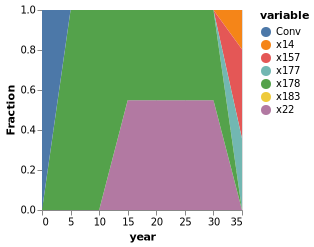

In [23]:

transpose(xk)
df1=DataFrame(xk',:auto)
df1[!,:year] = 5*collect(1:7)
df1=df1[!, any.(>(0), eachcol(df1))]
df1[!,:Conv] = zeros(7)
sNames="compromise ".*string.(collect(1:length(xk[:,1])))
push!(df1,zeros(size(df1)[2]))
df1[8,:Conv]=1
#rename!(df1,[:x28,:x29,:x30,:x44,:x48] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df1,[:x159,:x163] .=> [:alcPLA_minLCC,:alcPLA_3])
comp=df1 |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Fraction"}, color="variable:n",legend=:sNames) 
#save("./result-case-roadmap/compromise-netzero.svg", comp)
#comp


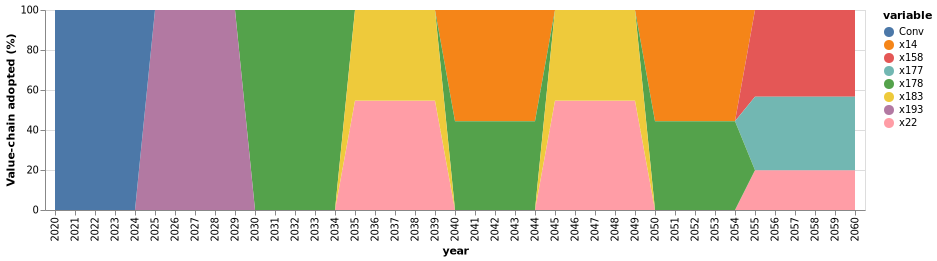

In [19]:
#only for this result

function conventional(i1,t)
    if t==7
        return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 1
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)
    end
end

function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    
end

conv=zeros(55)

conv[1]=100
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=100*conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=100*innovation(t,k,j)
    end
end
#conv[1:5].=100

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x31]=zeros(36)
#df[!,:x38]=zeros(36)
#df[!,:x164]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
split_yearly=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Value-chain adopted (%)"}, color="variable:n",legend=:sNames) 
if want_save>0
    save("./result-case-roadmap/split_yearly-"*output_key*".svg", split_yearly)
end
#save("./result-case-roadmap/split_yearly-netzero.svg", split_yearly)
split_yearly



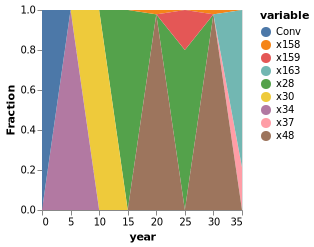

In [57]:
if want_save>0
    save("./result-case-roadmap/compromise-roadmap-"*output_key*".svg", comp)
end
comp

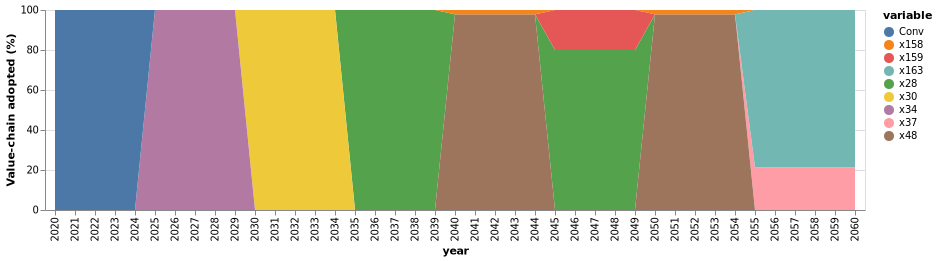

In [58]:
#only for this result

function conventional(i1,t)
    if t==7
        return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 1
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)
    end
end

function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    
end

conv=zeros(55)

conv[1]=100
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=100*conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=100*innovation(t,k,j)
    end
end
#conv[1:5].=100

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x31]=zeros(36)
#df[!,:x38]=zeros(36)
#df[!,:x164]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
split_yearly=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Value-chain adopted (%)"}, color="variable:n",legend=:sNames) 
if want_save>0
    save("./result-case-roadmap/split_yearly-"*output_key*".svg", split_yearly)
end
#save("./result-case-roadmap/split_yearly-netzero.svg", split_yearly)
split_yearly



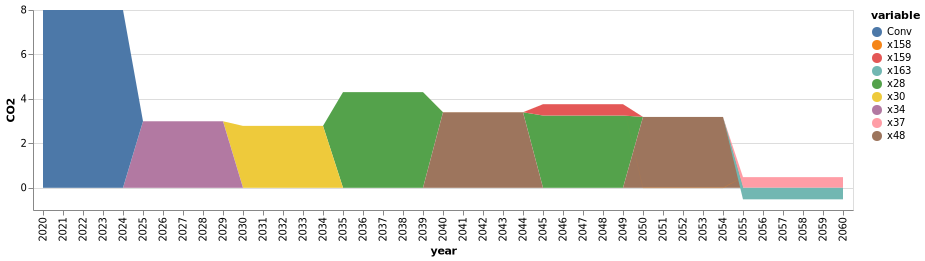

In [59]:
#only for this result

function conventional0(i1,t)
    if t==0
        if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[k1,t+1]-0.001 for k1=1:nrow(compromise));digits=2),5)
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
end

function conventional(i1,t)
    if t==7
        return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t] for k=1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,3]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return 0
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,3]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(co2fac[k,t]) for k=k1:k1)
end

conv=zeros(55)

conv[1]=initial[1,3]
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 2:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=innovation(t,k,j)
    end
end
conv[1:5].=initial[1,3]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x104]=zeros(36)
#df[!,:x201]=zeros(36)
#df[!,:x196]=zeros(36)
#df[!,:x126]=zeros(36)
#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
co2_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="CO2"}, color="variable:n",legend=:sNames) 

if want_save>0
    save("./result-case-roadmap/co2-roadmap-"*output_key*".svg", co2_inn)
end
co2_inn



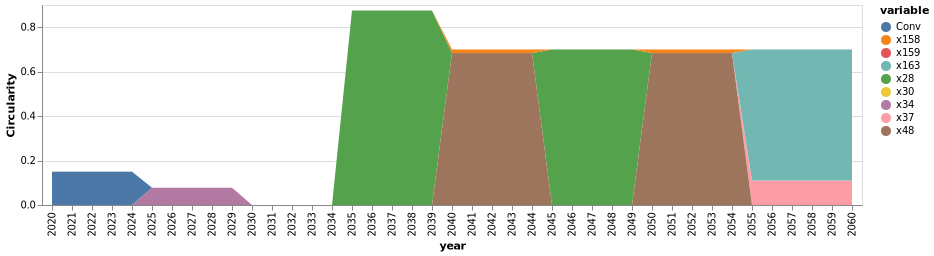

In [60]:
#=
function conventional(t)
    return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
end

function innovation(i1,k1,t)
     if mod(i1,5)>JuMP.values.(tk)[k1,t] && t<7
        t=t+1
    end
    if k1==1
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1)
    else
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,5])+JuMP.values.(xk)[k,t]*(compromise[k,6]) for k=k1:k1 )
    end
end
=#

function conventional(i1,t)
    if t==7
        return initial[1,5]*(1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return initial[1,4]*(1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))
        else
            return initial[1,4]
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return initial[1,4]*(1-sum_xks_atT)
    end
end


function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.0001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*(compromise[k,4]) for k=k1:k1)
end





conv=zeros(55)


inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
        
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=initial[1,5]

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
rename!(df,[:x269] .=> [:Conv])
#rename!(df,[:x1,:x93,:x104,:x222] .=> [:Conv,:pyLDPE1,:pyLDPE11,:alcPLA6])
#df[!,:alcPLA2]=zeros(36)
#df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="recycled/renewable content"}, color="variable:n",legend=:sNames) 
#df[!,:Conv]=zeros(36)
df[!,:x30]=zeros(41)
df[!,:x159]=zeros(41)
#df[!,:x201]=zeros(36)
#df[!,:x95]=zeros(36)
#rename!(df,[:x1,:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:Conv,:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])

#rename!(df,[:conv,:inn5,:inn10] .=> [:Conventional,:LDPE_Pyrolysis,:PLA_Alcoholysis])

circular_inn=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Circularity"}, color="variable:n",legend=:sNames) 
if want_save>0
    save("./result-case-roadmap/circularity-"*output_key*".svg", circular_inn)
end
#save("./result-case-roadmap/circularity-roadmap.svg", circular_inn)
circular_inn


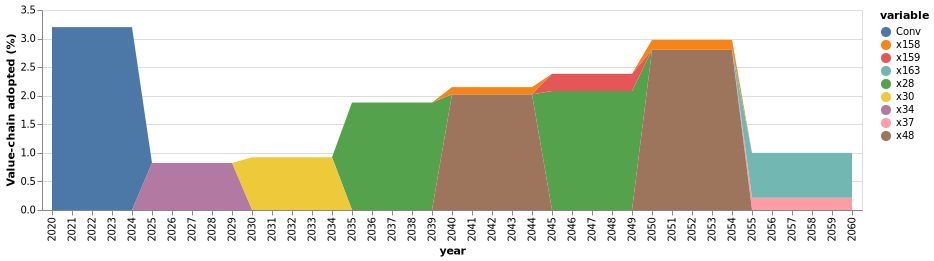

In [61]:
#only for this result

function conventional(i1,t)
    if t==7
        return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
    end
    if t==0
        if mod(i1,5)≥mod(round.(sum(JuMP.values.(tk)[1:nrow(compromise),t+1])-0.001;digits=4),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t+1]) > 0
            return (1-sum(JuMP.values.(xk)[k,t+1] for k in 1:nrow(compromise)))*initial[1,:Ocost]
        else
            return initial[1,:Ocost]
        end
    else
        sum_xks_atT=0
        for k1 in 1:nrow(compromise)
            if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
                sum_xks_atT+=JuMP.values.(xk)[k1,t+1]
            else
                sum_xks_atT+=JuMP.values.(xk)[k1,t]
            end
        end
            
        #if mod(i1,5)≥mod(round(sum(JuMP.values.(tk)[1:nrow(compromise),t+1]);digits=2),5) && sum(JuMP.values.(xk)[1:nrow(compromise),t:t+1])>0 && t>0
        #    t=t+1
        #end
        #return (1-sum(JuMP.values.(xk)[k,t] for k in 1:nrow(compromise)))
        return (1-sum_xks_atT)*initial[1,:Ocost]*0.982^(-1*tau[t])
    end
end

function innovation(i1,k1,t)
    if t==7
        return sum(JuMP.values.(xk)[k,t] for k=k1:k1)
    end
    if t==0 
        if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && JuMP.values.(xk)[k1,t+1] > 0
            t=1
            return (sum(JuMP.values.(xk)[k,t]*compromise[k,9] for k=k1:k1))            
        else
            return 0
        end
    end
    if mod(i1,5)≥mod(round(JuMP.values.(tk)[k1,t+1]-0.001;digits=4),5) && sum(JuMP.values.(xk)[k1,t:t+1])>0 && t>0
        t=t+1
    end
    return sum(JuMP.values.(xk)[k,t]*compromise[k,9]*0.968^(-1*tau[t]) for k=k1:k1)
    
end

conv=zeros(55)

#onv[1]=100
inn_co2=zeros(nrow(compromise),55)

for k in 1:nrow(compromise)
    inn_co2[k,1]=0
end
j=0
for t in 1:55
    if 0 ≤ t ≤ 5
        j=0
    elseif 6 ≤ t ≤ 10
        j=1
    elseif 11 ≤ t ≤ 15
        j=2
    elseif 16 ≤ t ≤ 20
        j=3
    elseif 21 ≤ t ≤ 25
        j=4
    elseif 26 ≤ t ≤ 30
        j=5
    elseif 31 ≤ t ≤ 35
        j=6
    else
        j=7
    end
    
    
    
    conv[t]=conventional(t,j)
    for k in 1:nrow(compromise)
        
        inn_co2[k,t]=innovation(t,k,j)
    end
end
#conv[1:5].=100

sNames = ["conv","inn1","inn2","inn3","inn4","inn5","inn6","inn7","inn8","inn9","inn10"]
xLabels = []
for i in 2020:2070
    push!(xLabels,string(i))
end

#df = DataFrame(year=xLabels, conv=conv, inn1=inn_co2[1,:],inn2=inn_co2[2,:],inn3=inn_co2[3,:],inn4=inn_co2[4,:],
#        inn5=inn_co2[5,:],inn6=inn_co2[6,:],inn7=inn_co2[7,:],inn8=inn_co2[8,:],inn9=inn_co2[9,:],inn10=inn_co2[10,:])
df = DataFrame(vcat(inn_co2,conv')',:auto)


df=df[1:41,:]

df=df[!, any.(>(0), eachcol(df))]
df[!,:year]=xLabels[1:41]
#rename!(df,[:x1,:x93,:x218,:x222] .=> [:Conv,:pyLDPE1,:alcPLA2,:alcPLA6])
#df[!,:pyLDPE11]=zeros(36)
rename!(df,[:x269] .=> [:Conv])
#df[!,:x31]=zeros(36)
#df[!,:x38]=zeros(36)
#df[!,:x164]=zeros(36)

#rename!(df,[:x94,:x95,:x104,:x109,:x196,:x198,:x199,:x200,:x201] .=> [:LABS12,:LABS13,:LABS22,:LABS27,:RecyclPLA2,:RecyclPLA4,:RecyclPLA5,:RecyclPLA6,:RecyclPLA7])
#rename!(df,[:x29,:x30,:x31,:x45,:x49] .=> [:pyLDPE_maxTheta,:pyLDPE_minGWP,:pyLDPE_minLCC,:pyLDPE_14,:pyLDPE_18])
#rename!(df,[:x160,:x164] .=> [:alcPLA_minLCC,:alcPLA_3])
o_cost=df |> stack |> @vlplot(:area, x=:year, y={:value, stack=:zero, title="Value-chain adopted (%)"}, color="variable:n",legend=:sNames) 
if want_save>0
    save("./result-case-roadmap/op_cost-"*output_key*".svg", o_cost)
end
#save("./result-case-roadmap/split_yearly-netzero.svg", split_yearly)
o_cost



In [230]:
for i in 1:7
    for k in 1:nrow(compromise)
        if xk[k,i]>0
            println(k,"--",xk[k,i])
            println(k,"--",tk[k,i])
            println("--")
            println(sum(xk[k,i]*co2fac[k,i]))
        #+(1-sum(xk[k,tt] for k in 1:nrow(compromise)))*initial[1,3]
            if i>1
                println((initial[1,3])*(xk[k,i-1]*tk[k,i]-(xk[k,i]*tk[k,i]-5*xk[k,i])))
            end
            
        end
    end
    println("-----------")
end

34--1.0
34--4.9999999894590434
--
2.992912129088112
-----------
30--1.0
30--5.0
--
2.7845637501961376
0.0
-----------
28--1.0
28--5.0
--
4.304542392882712
0.0
-----------
48--0.9783001808322878
48--4.998787859895857
--
3.3984441391705915
0.009486695064616413
158--0.021699819167684264
158--4.999999985605264
--
0.00399857101512502
2.498905304904042e-9
163--2.80216974443936e-14
163--0.0
--
2.4676006608213214e-14
1.1208678977757439e-12
-----------
28--0.7999085818763277
28--4.999174818482046
--
3.2521202746671802
0.005280558222541032
159--0.20009141812367226
159--4.996245602495604
--
0.5090189498874685
0.006009781766835864
-----------
48--0.9783001808322892
48--5.000000000000148
--
3.1881819890155767
-1.1652900866465643e-12
158--0.0216998191677108
158--4.823421570186088
--
-0.01239996610878006
0.03065375996704156
-----------
37--0.21357971637312256
37--4.996928570508013
--
0.4800269244273519
0.005247960318069289
163--0.7864202836268774
163--4.999154225670477
--
-0.5209541459785196
0.005321

In [178]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(xk[i,:].*co2fac[i,:];digits=2))
    end
end

28[0.0, 0.0, 4.3, 0.0, 3.25, 0.0, 0.0]
30[0.0, 2.78, 0.0, 0.0, 0.0, 0.0, 0.0]
34[2.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
37[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48]
48[0.0, 0.0, 0.0, 3.4, 0.0, 3.19, 0.0]
158[0.0, 0.0, 0.0, 0.0, 0.0, -0.01, -0.0]
159[0.0, 0.0, 0.0, 0.0, 0.51, 0.0, 0.0]
163[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.52]


In [177]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(xk[i,:];digits=2))
    end
end

28[0.0, 0.0, 1.0, 0.0, 0.8, 0.0, 0.0]
30[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
34[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
37[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21]
48[0.0, 0.0, 0.0, 0.98, 0.0, 0.98, 0.0]
158[0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.0]
159[0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0]
163[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.79]


In [37]:
for i in 1:240
    if sum(xk[i,:])>0
        print(i)
        println(round.(tk[i,:];digits=2))
    end
end

93[0.0, 0.0, 0.0, 5.0, 0.0, 5.0, 0.0]
94[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
103[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0]
108[0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 5.0]
195[5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0]
197[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0]
198[0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0]
199[0.0, 0.0, 0.0, 5.0, 0.0, 5.0, 0.0]
200[0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0]
